In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# To have reproducible results
seed = 5 
import numpy as np 
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

In [2]:
import json
import math
import os
from imgaug import augmenters as iaa
import cv2
from PIL import Image
from sklearn.utils import shuffle
from tensorflow.keras.utils import Sequence
# from keras_efficientnets import *
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import imgaug as ia
print(os.listdir('../input'))
%matplotlib inline

IMG_SIZE=256
BATCH_SIZE = 16

['efficientnet-keras-weights-b0b5', 'diabetic-retinopathy-resized', 'keras-pretrained-models', 'aptos2019-blindness-detection', 'tf-keras-pretrained-model-weights', 'efficentnet-b0b5-tensorflow-24-notop', 'densenet-keras']


In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [4]:
train_df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

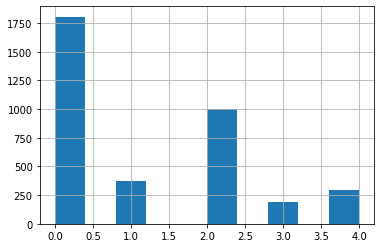

In [5]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

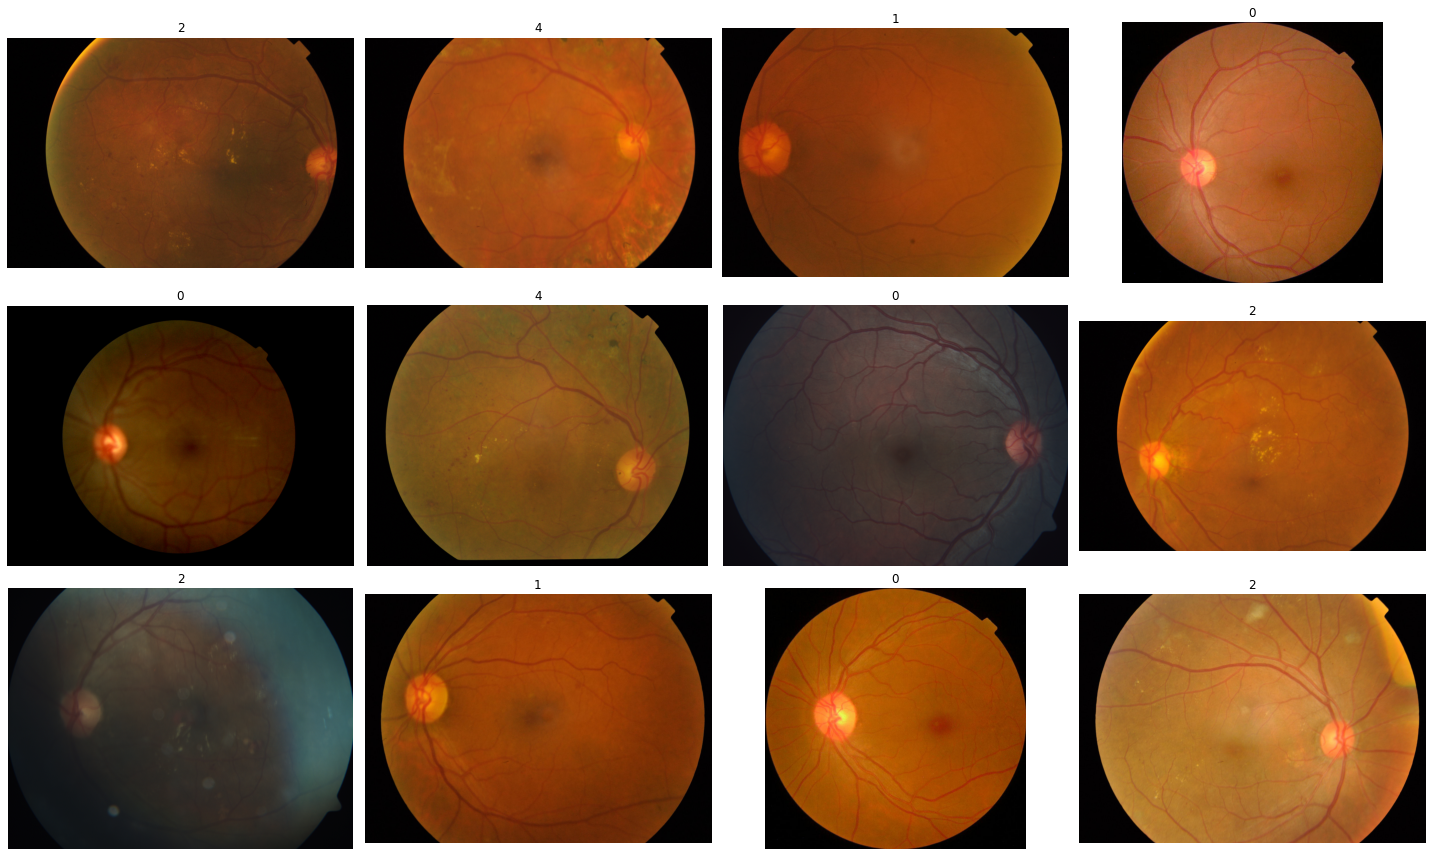

In [6]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [7]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def preprocess_image_with_ben(path, sigmaX=40):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

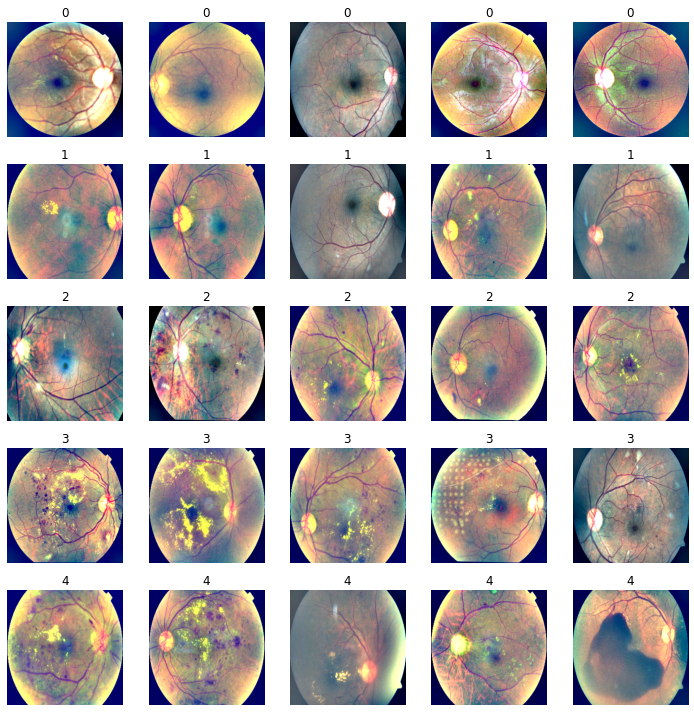

In [8]:
fig,ax=plt.subplots(5,5,figsize=(10,10))
for i in range(25):
    data=train_df[train_df['diagnosis']==i//5].reset_index()
    a=np.random.randint(len(data))
    img_code=data['id_code'][a]
    img=preprocess_image_with_ben(f'../input/aptos2019-blindness-detection/train_images/{img_code}.png')
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].set_title(data['diagnosis'][a])
        
plt.tight_layout()
plt.show()

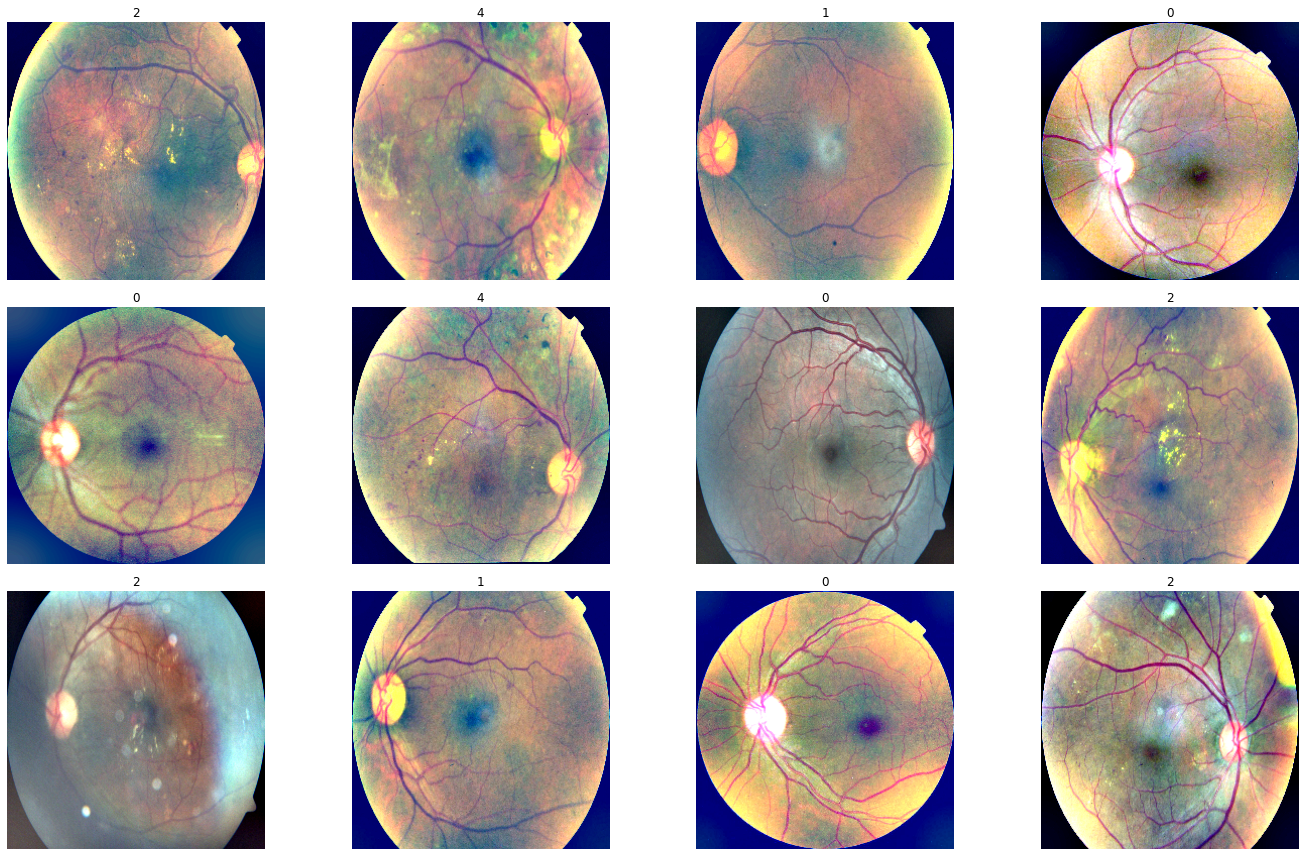

In [9]:
def display_samples_gaussian(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image_with_ben(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples_gaussian(train_df)

In [10]:
x_train=train_df['id_code'].values

In [11]:
train_df['diagnosis']=train_df['diagnosis'].astype(str)

In [12]:
y_train = pd.get_dummies(train_df['diagnosis']).values


print(y_train.shape)

(3662, 5)


In [13]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [14]:
N = train_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image_with_ben(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [25:05<00:00,  2.43it/s]


In [15]:
y_train = pd.get_dummies(train_df['diagnosis']).values


print(y_train.shape)

(3662, 5)


In [16]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [17]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.2, 
    random_state=2019
)

In [18]:
x_val=x_val/255

In [19]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [20]:
train_df['diagnosis']=train_df['diagnosis'].astype(str)

In [21]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,# randomly flip images
        rotation_range=360,
        rescale=1./255
    )
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [22]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [23]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

In [24]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

In [25]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
# #         X_val, y_val =self.val_generator[0],self.val_generator[1]
# #         y_val = y_val.sum(axis=1) - 1
#         y_pred=self.model.predict_generator(val_generator,steps=np.ceil(val_generator.samples/BATCH_SIZE).astype(int))
# #         y_pred = self.model.predict(X_val) > 0.5
# #         y_pred = y_pred.astype(int).sum(axis=1) - 1
#         y_pred=np.argmax(y_pred,axis=1)

    
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1
        
        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            model.save_weights('model.h5')
            model_json = model.to_json()
            with open('model.json', "w") as json_file:
                json_file.write(model_json)
            json_file.close()

        return

In [27]:
from tensorflow.keras.applications import DenseNet169
densenet169 = DenseNet169(
    weights='../input/tf-keras-pretrained-model-weights/No Top/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

In [28]:
import tensorflow as tf
import keras
METRICS = [
      'accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

In [29]:
def build_model():
    model = Sequential()
    model.add(densenet169)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    for layer in model.layers:
        layer.trainable=True
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=METRICS
    )
    
    return model

In [30]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1704960   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 14,352,965
Trainable params: 14,194,565
Non-trainable params: 158,400
______________________________________

In [31]:
# kappa_metrics = Metrics()
# # filename='1500images_lr003.h5'
# # checkpoint=ModelCheckpoint(filename,monitor='val_loss',save_best_only='True')
# est=EarlyStopping(monitor='val_loss',patience=5, min_delta=0.005)
# call_backs=[est,kappa_metrics]

history = model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    validation_data=(x_val,y_val),
     epochs=18,
    #callbacks=call_backs
)

2021-12-09 07:49:50.615160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/18


2021-12-09 07:50:11.315338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


184/183 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.9143 - precision: 0.8667 - recall: 0.8380 - auc: 0.9429

2021-12-09 07:51:14.821742: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 576454656 exceeds 10% of free system memory.
2021-12-09 07:51:15.413867: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 576454656 exceeds 10% of free system memory.


183/183 [==============================] - 93s 353ms/step - loss: 0.2940 - accuracy: 0.9143 - precision: 0.8667 - recall: 0.8380 - auc: 0.9429 - val_loss: 0.2006 - val_accuracy: 0.9959 - val_precision: 0.9805 - val_recall: 0.8287 - val_auc: 0.9804
Epoch 2/18
183/183 [==============================] - 57s 313ms/step - loss: 0.1784 - accuracy: 0.9061 - precision: 0.9362 - recall: 0.8889 - auc: 0.9788 - val_loss: 0.1343 - val_accuracy: 0.9809 - val_precision: 0.9529 - val_recall: 0.9190 - val_auc: 0.9880
Epoch 3/18
183/183 [==============================] - 56s 308ms/step - loss: 0.1576 - accuracy: 0.8791 - precision: 0.9390 - recall: 0.9080 - auc: 0.9837 - val_loss: 0.1170 - val_accuracy: 0.8963 - val_precision: 0.9537 - val_recall: 0.9368 - val_auc: 0.9908
Epoch 4/18
183/183 [==============================] - 57s 310ms/step - loss: 0.1498 - accuracy: 0.8843 - precision: 0.9408 - recall: 0.9145 - auc: 0.9853 - val_loss: 0.1083 - val_accuracy: 0.8827 - val_precision: 0.9680 - val_recall: 

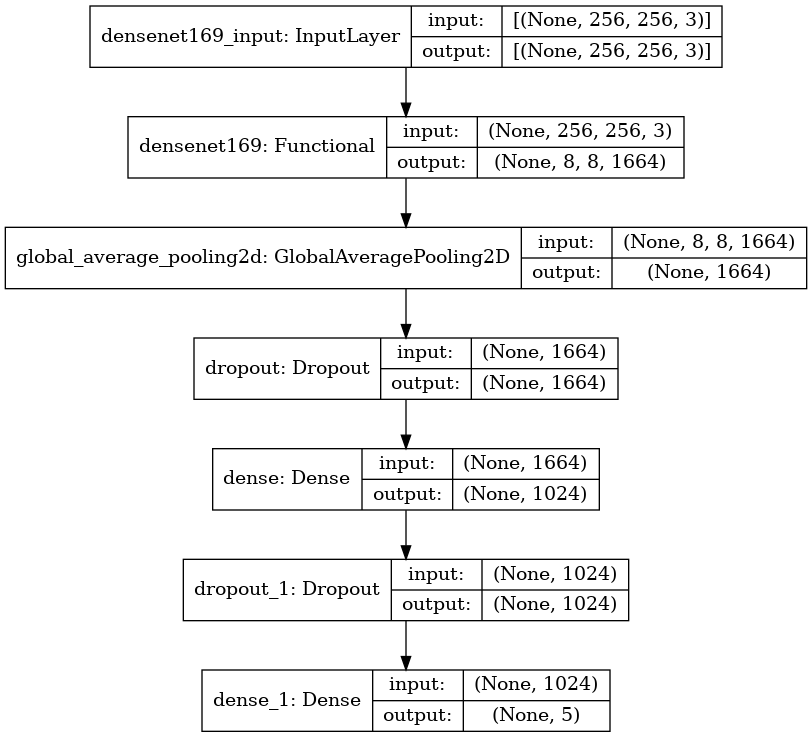

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

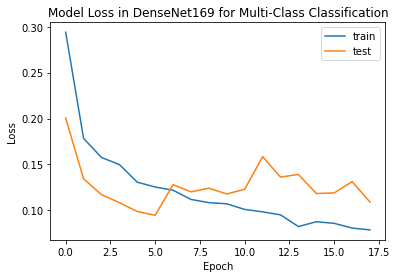

In [33]:
import json
with open('history.json', 'w') as f:
    json.dump(history.history, f)

import matplotlib.pyplot as pyplot

pyplot.title('Model Loss in DenseNet169 for Multi-Class Classification')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
Xception_train_loss = history.history['loss']
Xception_test_loss = history.history['val_loss']
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.savefig('DenseNet169_Loss.png')
pyplot.legend()
pyplot.show()


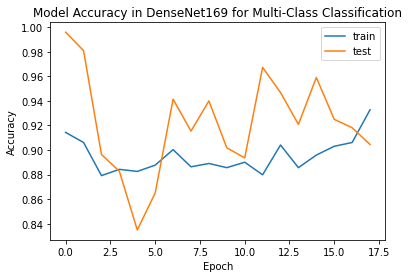

In [34]:
import matplotlib.pyplot as pyplot
pyplot.title('Model Accuracy in DenseNet169 for Multi-Class Classification')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
Xception_train_accuracy = history.history['accuracy']
Xception_test_accuracy= history.history['val_accuracy']
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.savefig('DenseNet169_ACC.png')
pyplot.legend()
pyplot.show()

In [35]:
model.save('model.h5')

In [36]:
score = model.evaluate(x_val,y_val)
print("\n\n\t\t\t\t\tValidation Result\n")
f1_score = (2*score[2]*score[3])/(score[2]+score[3])
print("\n","Loss: ", score[0],"\n", "Accuracy: ", score[1],"\n", "Precision: ",score[2], "\n","Recall: ",score[3],"\n","F1-Score: ",f1_score,"\n","AUC: ",score[4])

2021-12-09 08:08:24.769798: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 576454656 exceeds 10% of free system memory.
2021-12-09 08:08:25.540854: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 576454656 exceeds 10% of free system memory.


23/23 [==============================] - 2s 93ms/step - loss: 0.1089 - accuracy: 0.9045 - precision: 0.9595 - recall: 0.9519 - auc: 0.9914


					Validation Result


 Loss:  0.1088918000459671 
 Accuracy:  0.9045020341873169 
 Precision:  0.9594953656196594 
 Recall:  0.9519104361534119 
 F1-Score:  0.9556878514514668 
 AUC:  0.9913727045059204


In [37]:
print('\nEpoch No.  Train Loss  Train Accuracy      Val Loss      Val Accuracy')
epochs = 18
Epochs = epochs
for i in range(epochs):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history.history['loss'][i], history.history['accuracy'][i], history.history['val_loss'][i], history.history['val_accuracy'][i]))


Epoch No.  Train Loss  Train Accuracy      Val Loss      Val Accuracy
       1   0.294049 	   0.914305 	   0.200558 	   0.995907
       2   0.178352 	   0.906111 	   0.134301 	   0.980900
       3   0.157559 	   0.879140 	   0.116994 	   0.896317
       4   0.149800 	   0.884261 	   0.108281 	   0.882674
       5   0.130593 	   0.882554 	   0.098623 	   0.834925
       6   0.125339 	   0.887675 	   0.094478 	   0.864939
       7   0.121812 	   0.900307 	   0.127947 	   0.941337
       8   0.111801 	   0.886309 	   0.120077 	   0.915416
       9   0.108297 	   0.889041 	   0.124040 	   0.939973
      10   0.107050 	   0.885626 	   0.117762 	   0.901774
      11   0.100908 	   0.890065 	   0.122903 	   0.893588
      12   0.098245 	   0.879822 	   0.158447 	   0.967258
      13   0.094988 	   0.904063 	   0.136163 	   0.946794
      14   0.082219 	   0.885626 	   0.139061 	   0.920873
      15   0.087522 	   0.895869 	   0.118297 	   0.959072
      16   0.085710 	   0.903039 	   0.11886

In [38]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['TruePositives','TrueNegatives','FalsePositives','FalseNegatives'])
history = model.fit(data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    validation_data=(x_val,y_val),
     epochs=9,
    #callbacks=call_backs
)

Epoch 1/9
184/183 [==============================] - ETA: 0s - loss: 0.2390 - true_positives: 5423.0000 - true_negatives: 7859.0000 - false_positives: 515.0000 - false_negatives: 848.0000

2021-12-09 08:09:43.334314: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 576454656 exceeds 10% of free system memory.


183/183 [==============================] - 81s 338ms/step - loss: 0.2390 - true_positives: 5423.0000 - true_negatives: 7859.0000 - false_positives: 515.0000 - false_negatives: 848.0000 - val_loss: 4.2884 - val_true_positives: 1368.0000 - val_true_negatives: 1316.0000 - val_false_positives: 831.0000 - val_false_negatives: 150.0000
Epoch 2/9
183/183 [==============================] - 57s 309ms/step - loss: 0.2414 - true_positives: 5396.0000 - true_negatives: 7921.0000 - false_positives: 453.0000 - false_negatives: 875.0000 - val_loss: 25.2649 - val_true_positives: 733.0000 - val_true_negatives: 2147.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 785.0000
Epoch 3/9
183/183 [==============================] - 57s 312ms/step - loss: 0.2142 - true_positives: 5476.0000 - true_negatives: 7926.0000 - false_positives: 448.0000 - false_negatives: 795.0000 - val_loss: 0.3926 - val_true_positives: 1072.0000 - val_true_negatives: 2141.0000 - val_false_positives: 6.0000 - val_false_nega

In [39]:
score = model.evaluate(x_val,y_val)
print('\t','\t','\t','***In Validation Data***','\n')
print("\n","Loss: ", score[0],"\n", "TP: ", score[1],"\n", "TN: ",score[2], "\n","FP: ",score[3],"\n","FN: ",score[4])

23/23 [==============================] - 2s 93ms/step - loss: 0.2419 - true_positives: 1264.0000 - true_negatives: 2106.0000 - false_positives: 41.0000 - false_negatives: 254.0000
	 	 	 ***In Validation Data*** 


 Loss:  0.24192878603935242 
 TP:  1264.0 
 TN:  2106.0 
 FP:  41.0 
 FN:  254.0


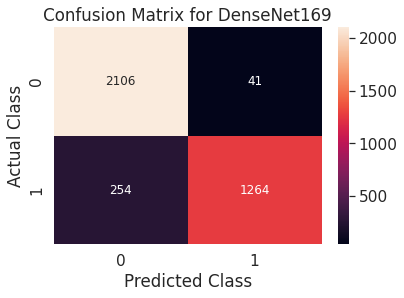

In [41]:
import matplotlib.pyplot as pyplot
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


array = [[2106,41],
         [254,1264]]

df_cm = pd.DataFrame(array, range(2), range(2))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt = 'g') # font size
pyplot.title('Confusion Matrix for DenseNet169')
pyplot.ylabel('Actual Class')
pyplot.xlabel('Predicted Class')
pyplot.savefig('DenseNet169_Validation.png')
pyplot.show()